In [13]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from matplotlib import pyplot as plt 
from pyspark_dist_explore import hist, Histogram, distplot
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
spark = SparkSession.builder.master("local[*]").appName("ACS PUMS 2013-2017 Data Analysis").getOrCreate()

In [3]:
#loading the dataset as DataFrame API, one at a time cleaning and removing it unitll next load
dataA = spark.read.csv('data/csv_pus/csv_pus/psam_pusa.csv', header=True, inferSchema=True)
dataB = spark.read.csv('data/csv_pus/csv_pus/psam_pusb.csv', header=True, inferSchema=True)
dataC = spark.read.csv('data/csv_pus/csv_pus/psam_pusc.csv', header=True, inferSchema=True)
dataD = spark.read.csv('data/csv_pus/csv_pus/psam_pusd.csv', header=True, inferSchema=True)

In [4]:
#selecting the columns we need - tranformation
cols = ['REGION', 'ST', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DREM', 'ENG', 'FER', 'GCL', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'JWMNP', 'JWRIP', 'JWTR', 'LANX', 'MAR', 'RELP', 'SCH', 'SCHG', 'SCHL', 'SEX', 'FOD1P', 'FOD2P', 'INDP', 'JWAP', 'JWDP', 'LANP', 'POVPIP', 'POWSP'] 

dataA = dataA.select(*cols)
dataB = dataB.select(*cols)
dataC = dataC.select(*cols)
dataD = dataD.select(*cols)

In [5]:
#wrangle data dictionary to perform mapping
#map categorical values to data-dictionary
#combine the 4 data files
#perform the anlaysis such as one-hot encoding etc
#clustering
#mlib
#graphX based on Relation attribute

In [5]:
#load data dictionary
#join woth data Dictionary only during plotting as legend
dataDict = spark.read.csv('data/csv_pus/csv_pus/PUMS_Data_Dictionary_2013-2017.csv', header=True, inferSchema=True)

In [6]:
dataDict = dataDict.dropna(how='any')
dataDict = dataDict.select('RT', 'Record Type', '_c6')

In [7]:
dataDict = dataDict.filter(f.col('RT').isin(cols))

In [8]:
dataDict = dataDict.withColumnRenamed('RT', 'colName')
dataDict = dataDict.withColumnRenamed('Record Type', 'code')
dataDict = dataDict.withColumnRenamed('_c6', 'abbrev')
dataDict.show()

+-------+----+--------------------+
|colName|code|              abbrev|
+-------+----+--------------------+
| REGION|   1|           Northeast|
| REGION|   2|             Midwest|
| REGION|   3|               South|
| REGION|   4|                West|
| REGION|   9|         Puerto Rico|
|     ST|   1|          Alabama/AL|
|     ST|   2|           Alaska/AK|
|     ST|   4|          Arizona/AZ|
|     ST|   5|         Arkansas/AR|
|     ST|   6|       California/CA|
|     ST|   8|         Colorado/CO|
|     ST|   9|      Connecticut/CT|
|     ST|  10|         Delaware/DE|
|     ST|  11|District of Colum...|
|     ST|  12|          Florida/FL|
|     ST|  13|          Georgia/GA|
|     ST|  15|           Hawaii/HI|
|     ST|  16|            Idaho/ID|
|     ST|  17|         Illinois/IL|
|     ST|  18|          Indiana/IN|
+-------+----+--------------------+
only showing top 20 rows



In [15]:
#get the session details
#spark.sparkContext.getConf().getAll()
dataDict.filter(dataDict.colName == 'SEX').show()

+-------+----+------+
|colName|code|abbrev|
+-------+----+------+
|    SEX|   1|  Male|
|    SEX|   2|Female|
+-------+----+------+



In [10]:
spark.sparkContext.uiWebUrl

u'http://sandbox-host.hortonworks.com:4041'

In [11]:
#merge all the dataframes into one dataframe
df = dataA.union(dataB)
df = df.union(dataC)
df = df.union(dataD)

In [12]:
#clearing the dataframes to free up the memory
dataA.unpersist(True)
dataB.unpersist(True)
dataC.unpersist(True)
dataD.unpersist(True)

DataFrame[REGION: int, ST: int, AGEP: int, CIT: int, CITWP: int, COW: int, DDRS: int, DEAR: int, DEYE: int, DREM: int, ENG: int, FER: int, GCL: int, HINS1: int, HINS2: int, HINS3: int, HINS4: int, HINS5: int, HINS6: int, HINS7: int, JWMNP: int, JWRIP: int, JWTR: int, LANX: int, MAR: int, RELP: int, SCH: int, SCHG: int, SCHL: int, SEX: int, FOD1P: int, FOD2P: int, INDP: int, JWAP: int, JWDP: int, LANP: int, POVPIP: int, POWSP: int]

In [16]:
#finding the insights on data, 
#the vision etc difficulties dmographics and mostly on high gage groups
# Create some selections on this data
filtered_by_gender_m = df.filter(f.col('SEX') == '1').select('INDP').join(dataDict, [dataDict.colName == 'INDP', dataDict.code.cast('int') == df.INDP ], 'inner').select(f.col('abbrev').alias('INDUSTRY_m'))
filtered_by_gender_f = df.filter(f.col('SEX') == '2').select('INDP').join(dataDict, [dataDict.colName == 'INDP', dataDict.code.cast('int') == df.INDP ], 'inner').select(f.col('abbrev').alias('INDUSTRY_f'))            

filtered_by_age_50_plus = df.filter(f.col('AGEP') > 50).select('COW').join(dataDict, [dataDict.colName == 'COW', dataDict.code.cast('int') == df.COW  ], 'inner').select(f.col('abbrev').alias('ClassOfWorker_50_plus'))
filtered_by_age_50_minus = df.filter(f.col('AGEP') <= 50).select('COW').join(dataDict, [dataDict.colName == 'COW', dataDict.code.cast('int') == df.COW ], 'inner').select(f.col('abbrev').alias('ClassOfWorker_50_minus'))                                                                            
                                                                             

In [17]:
#aggregating the data for easier and memory efficient pandas plotting
vizM = filtered_by_gender_m.groupBy('INDUSTRY_m').count().sort('count', ascending = False)
vizF = filtered_by_gender_f.groupBy('INDUSTRY_f').count().sort('count', ascending = False)

viz50Minus = filtered_by_age_50_minus.groupBy('ClassOfWorker_50_minus').count().sort('count', ascending = False)
viz50Plus = filtered_by_age_50_plus.groupBy('ClassOfWorker_50_plus').count().sort('count', ascending = False)

/home/azure_hdp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


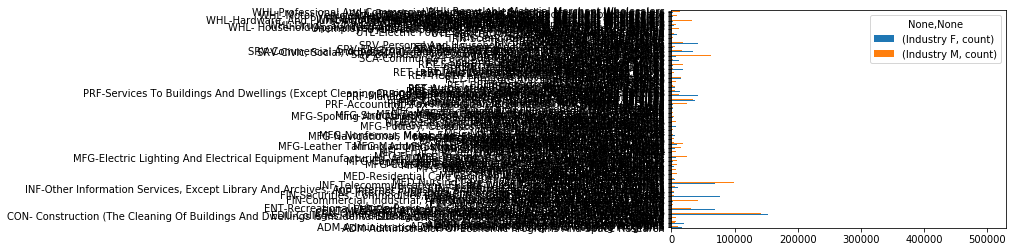

In [30]:
#panadas plotting visualizations
#visualization issues with long labels, so use string indexer
C = vizM.toPandas()
D = vizF.toPandas()

pd.concat({
    'Industry M': C.set_index('INDUSTRY_m'), 'Industry F': D.set_index('INDUSTRY_f')
}, axis=1).plot.barh()

/home/azure_hdp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


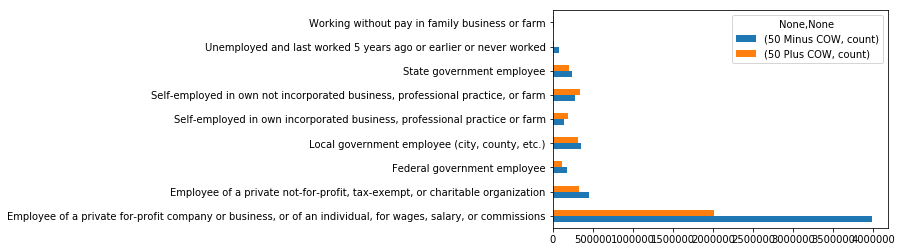

In [29]:
A = viz50Minus.toPandas()
B = viz50Plus.toPandas()

pd.concat({
    '50 Plus COW': B.set_index('ClassOfWorker_50_plus'), '50 Minus COW': A.set_index('ClassOfWorker_50_minus')
}, axis=1).plot.barh()

In [14]:
filtered_by_gender_m.groupBy('INDUSTRY_m').count().sort('count', ascending = False).show()

+--------------------+------+
|          INDUSTRY_m| count|
+--------------------+------+
|CON- Construction...|504616|
|ENT-Restaurants A...|247359|
|EDU-Elementary An...|141077|
|EDU-Colleges, Uni...|120703|
|ADM-Justice, Publ...|110775|
|       MED-Hospitals| 98906|
|TRN-Truck Transpo...| 92165|
|PRF-Computer Syst...| 91827|
|  RET-Grocery Stores| 86265|
|ENT-Other Amuseme...| 74951|
|     FIN-Real Estate| 72686|
| AGR-Crop Production| 67632|
|PRF-Landscaping S...| 67494|
|PRF-Architectural...| 66626|
|SRV-Automotive Re...| 62346|
|FIN-Insurance Car...| 59092|
|PRF-Management, S...| 56625|
|MFG-Motor Vehicle...| 55697|
|RET-Automobile De...| 53708|
|RET-Department An...| 52198|
+--------------------+------+
only showing top 20 rows



In [15]:
filtered_by_gender_f.groupBy('INDUSTRY_f').count().sort('count', ascending = False).show()

+--------------------+------+
|          INDUSTRY_f| count|
+--------------------+------+
|EDU-Elementary An...|450201|
|       MED-Hospitals|310234|
|ENT-Restaurants A...|295281|
|EDU-Colleges, Uni...|153147|
|MED-Nursing Care ...| 96383|
|SCA-Child Day Car...| 95606|
|FIN-Insurance Car...| 93697|
|  RET-Grocery Stores| 92578|
|RET-Department An...| 87041|
|SCA-Individual An...| 78755|
|MED-Offices Of Ph...| 77805|
|     FIN-Real Estate| 76484|
|FIN-Banking And R...| 75193|
|ENT-Other Amuseme...| 69577|
|MED-Outpatient Ca...| 69118|
|MED-Home Health C...| 68947|
|ADM-Justice, Publ...| 60060|
|CON- Construction...| 58157|
|  PRF-Legal Services| 55718|
| RET-Clothing Stores| 52864|
+--------------------+------+
only showing top 20 rows



In [16]:
filtered_by_age_50_minus.groupBy('ClassOfWorker_50_minus').count().sort('count', ascending = False).show()


+----------------------+-------+
|ClassOfWorker_50_minus|  count|
+----------------------+-------+
|  Employee of a pri...|3982141|
|  Employee of a pri...| 448549|
|  Local government ...| 356139|
|  Self-employed in ...| 275757|
|  State government ...| 246507|
|  Federal governmen...| 178021|
|  Self-employed in ...| 140571|
|  Unemployed and la...|  73816|
|  Working without p...|  19490|
+----------------------+-------+



In [17]:
filtered_by_age_50_plus.groupBy('ClassOfWorker_50_plus').count().sort('count', ascending = False).show()


+---------------------+-------+
|ClassOfWorker_50_plus|  count|
+---------------------+-------+
| Employee of a pri...|2014573|
| Self-employed in ...| 345702|
| Employee of a pri...| 331590|
| Local government ...| 316499|
| State government ...| 207361|
| Self-employed in ...| 191325|
| Federal governmen...| 119587|
| Working without p...|  17364|
| Unemployed and la...|  15551|
+---------------------+-------+



In [31]:
#determing the inDustry of work using Machine Learning
#features = [AGEP, SCH, SCHG, SCHL, SEX, FOD1P, FOD2P, COW]
#target = INDP

#AGEP > 17 takes care of COW and Schooling
dfX = df.filter((f.col('AGEP') > 17) & (f.col('INDP').isNotNull())).select('AGEP', 'SCHL', 'SEX', 'FOD1P', 'FOD2P', 'COW', 'INDP') #nit doing joimn with the dataDict as during one hot encoding the column names might have spaces and doesn't make sense, c an use join during plotting and graphing
dfX = dfX.fillna({'FOD1P': 0, 'FOD2P':0})


In [32]:
dfX.show()

+----+----+---+-----+-----+---+----+
|AGEP|SCHL|SEX|FOD1P|FOD2P|COW|INDP|
+----+----+---+-----+-----+---+----+
|  55|  20|  2|    0|    0|  1|5380|
|  56|  16|  1|    0|    0|  6|8880|
|  63|  21|  2| 6107|    0|  3|7860|
|  20|  16|  1|    0|    0|  1| 770|
|  78|   1|  2|    0|    0|  2|1880|
|  59|  16|  1|    0|    0|  1|6380|
|  56|  18|  2|    0|    0|  1|7270|
|  72|  21|  1| 5500|    0|  4|7860|
|  52|  19|  2|    0|    0|  3| 570|
|  18|  16|  2|    0|    0|  1|9090|
|  22|  21|  1| 5301|    0|  1|8590|
|  22|  21|  2| 3600|    0|  2|7870|
|  52|  18|  2|    0|    0|  1|5390|
|  58|  16|  1|    0|    0|  1|4970|
|  41|  16|  2|    0|    0|  3|9370|
|  38|  16|  1|    0|    0|  4| 580|
|  69|  18|  2|    0|    0|  1|7080|
|  46|  16|  1|    0|    0|  1|6170|
|  55|  18|  1|    0|    0|  1|6470|
|  52|  21|  2| 6107|    0|  1| 490|
+----+----+---+-----+-----+---+----+
only showing top 20 rows



In [33]:
#onehotencoding of cateforical variablesa for classification
categCol = ['SCHL', 'SEX', 'FOD1P', 'FOD2P', 'COW']
numericCol = ['AGEP']
stages = []

#StringIndexing and oneHotEncoding of categorical features
for cols in categCol:
    stringIndexer = StringIndexer(inputCol=cols, outputCol=cols+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[cols + 'classVec'])
    stages += [stringIndexer, encoder]

#String indexing of label
labelStringIndexer = StringIndexer(inputCol='INDP', outputCol='label')
stages += [labelStringIndexer]

assemblerInput = [c + 'classVec' for c in categCol] + numericCol
assembler = VectorAssembler(inputCols=assemblerInput, outputCol="features")
stages += [assembler]





In [34]:
#creating a ML pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dfX)
dfX = pipelineModel.transform(dfX)
dfX = dfX.select('label', 'features')

In [35]:
dfX.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  9.0|(379,[3,24,197,37...|
|140.0|(379,[0,23,24,197...|
|  0.0|(379,[1,28,197,37...|
|  1.0|(379,[0,23,24,197...|
|201.0|(379,[13,24,197,3...|
| 58.0|(379,[0,23,24,197...|
| 19.0|(379,[5,24,197,37...|
|  0.0|(379,[1,23,94,197...|
| 55.0|(379,[2,24,197,37...|
| 92.0|(379,[0,24,197,37...|
| 10.0|(379,[1,23,42,197...|
|  4.0|(379,[1,31,197,37...|
| 59.0|(379,[5,24,197,37...|
|  6.0|(379,[0,23,24,197...|
| 27.0|(379,[0,24,197,37...|
|192.0|(379,[0,23,24,197...|
|156.0|(379,[5,24,197,37...|
| 14.0|(379,[0,23,24,197...|
|118.0|(379,[5,23,24,197...|
| 75.0|(379,[1,28,197,37...|
+-----+--------------------+
only showing top 20 rows



In [36]:
#train test split
train, test = dfX.randomSplit([0.8, 0.2], seed=2020)
print("train count: " + str(train.count()))
print("test count: " + str(test.count()))

train count: 7310377
test count: 1826504


In [37]:
dctClf = DecisionTreeClassifier(featuresCol='features' ,labelCol='label', maxDepth=3)
dctModel = dctClf.fit(train)
predictions = dctModel.transform(test)
predictions.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
|       1.0|[0.02129429874201...|
+----------+--------------------+
only showing top 10 rows



In [38]:
#peerformance metric, evaluation
evaluator = MulticlassClassificationEvaluator()
print("Area under Curve ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Area under Curve ROC: 0.0548647132915


In [39]:
#RandomForesrt classifier
rfClf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rfClf.fit(train)
predictions = rfModel.transform(test)
predictions.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       2.0|[0.02988559573853...|
|       2.0|[0.02988559573853...|
|       1.0|[0.03079158420812...|
|       1.0|[0.03079158420812...|
|       1.0|[0.03079158420812...|
|       1.0|[0.03079158420812...|
|       1.0|[0.03079158420812...|
|       1.0|[0.04997002161901...|
|       1.0|[0.04613128730467...|
|       1.0|[0.04613128730467...|
+----------+--------------------+
only showing top 10 rows



In [40]:
evaluator = MulticlassClassificationEvaluator()
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

Accuracy: 0.160610652919
